In [1]:
import habitat

import numpy as np
import random

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Habitat-API
# All the boilerplate code in the habitat-sim to set sensor config 
# and agent config is abstracted out in the Habitat-API config system.
# Default config is at habitat/config/default.py. 
# You can override defaults by specifying them in a separate file and pass it to the get_config function
# or defrost the config object, override parameters and freeze the config

config = habitat.get_config(config_paths='../configs/tasks/pointnav_rgbd.yaml')
config.defrost()
config.DATASET.DATA_PATH = '../data/datasets/pointnav/habitat-test-scenes/v1/val/val.json.gz'
config.DATASET.SCENES_DIR = '../data/scene_datasets/'
config.freeze()

env = habitat.Env(config=config)

2019-11-19 12:49:35,917 Initializing dataset PointNav-v1
2019-11-19 12:49:35,971 initializing sim Sim-v0
I1119 12:49:39.618830 22011 simulator.py:127] Loaded navmesh ../data/scene_datasets/habitat-test-scenes/skokloster-castle.navmesh
2019-11-19 12:49:39,640 Initializing task Nav-v0


# Scene semantic annotations

In [3]:
def print_scene_recur(scene, limit_output=10):
    count = 0
    for level in scene.levels:
        print(
            f"Level id:{level.id}, center:{level.aabb.center},"
            f" dims:{level.aabb.sizes}"
        )
        for region in level.regions:
            print(
                f"Region id:{region.id}, category:{region.category.name()},"
                f" center:{region.aabb.center}, dims:{region.aabb.sizes}"
            )
            for obj in region.objects:
                print(
                    f"Object id:{obj.id}, category:{obj.category.name()},"
                    f" center:{obj.aabb.center}, dims:{obj.aabb.sizes}"
                )
                count += 1
                if count >= limit_output:
                    return None

# Print semantic annotation information (id, category, bounding box details) 
# for the current scene in a hierarchical fashion
scene = env.sim.semantic_annotations()
print_scene_recur(scene, limit_output=15)
    
env.close() 
# Note: Since only one OpenGL is allowed per process, 
# you have to close the current env before instantiating a new one.

# Take random actions and display sensor data

In [4]:
from PIL import Image
import numpy as np
from habitat_sim.utils.common import d3_40_colors_rgb
# import habitat_sim.utils
def display_sample(rgb_obs, semantic_obs, depth_obs):
    rgb_img = Image.fromarray(rgb_obs, mode="RGB")
    
    semantic_img = Image.new("P", (semantic_obs.shape[1], semantic_obs.shape[0]))
    semantic_img.putpalette(d3_40_colors_rgb.flatten())
    semantic_img.putdata((semantic_obs.flatten() % 40).astype(np.uint8))
    semantic_img = semantic_img.convert("RGBA")
    
    depth_img = Image.fromarray((depth_obs * 255).astype(np.uint8), mode="L")

    arr = [rgb_img, semantic_img, depth_img]
    
    titles = ['rgb', 'semantic', 'depth']
    plt.figure(figsize=(12 ,8))
    for i, data in enumerate(arr):
        ax = plt.subplot(1, 3, i+1)
        ax.axis('off')
        ax.set_title(titles[i])
        plt.imshow(data)
    plt.show()

2019-11-19 12:49:46,104 Initializing dataset PointNav-v1
2019-11-19 12:49:46,107 initializing sim Sim-v0
I1119 12:49:46.970242 22011 simulator.py:127] Loaded navmesh ../data/scene_datasets/habitat-test-scenes/skokloster-castle.navmesh
2019-11-19 12:49:46,971 Initializing task Nav-v0


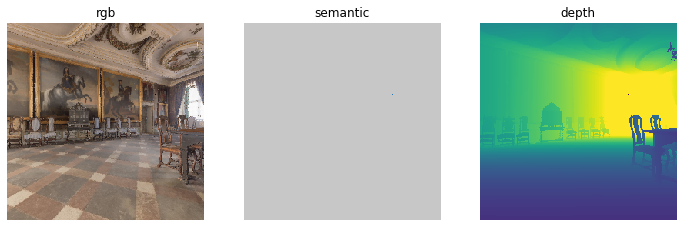

turn left


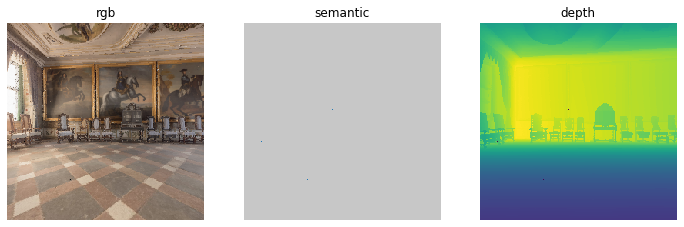

move_forward


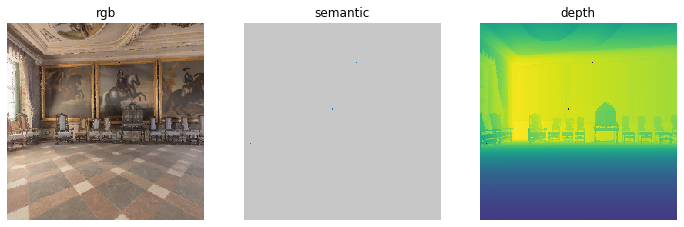

turn right


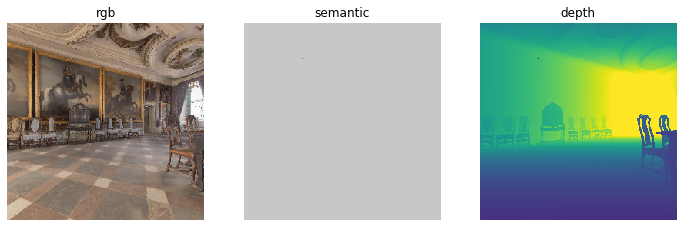

move_forward


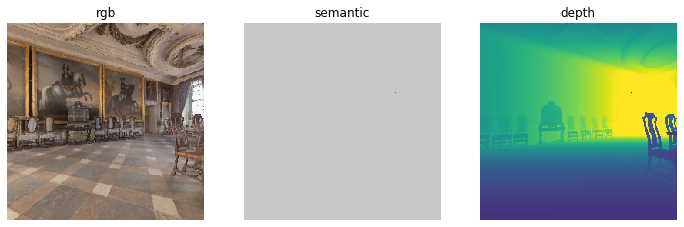

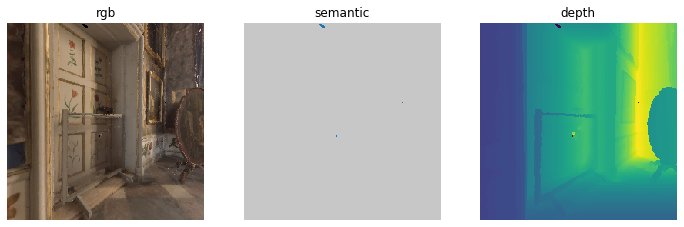

turn left


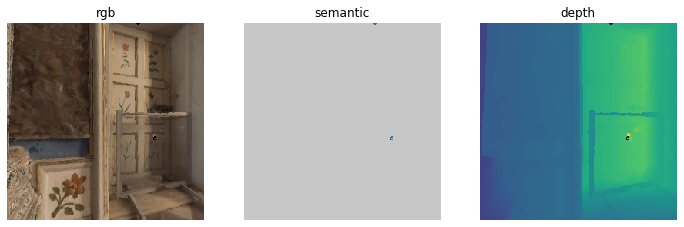

turn right


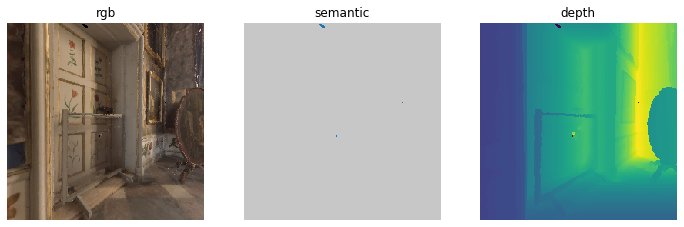

turn left


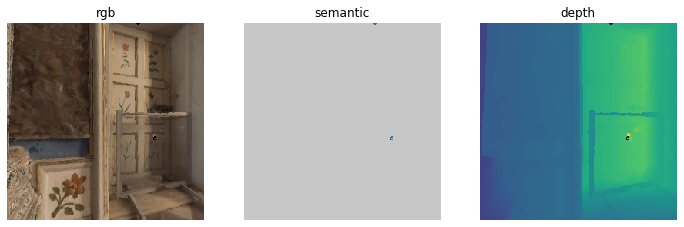

turn left


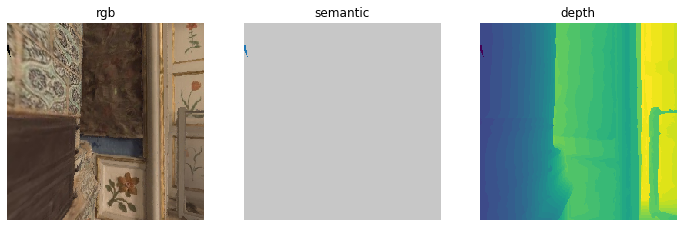

In [5]:
config = habitat.get_config(config_paths='../configs/tasks/pointnav_rgbd.yaml')
config.defrost()
config.DATASET.DATA_PATH = '../data/datasets/pointnav/habitat-test-scenes/v1/val/val.json.gz'
config.DATASET.SCENES_DIR = '../data/scene_datasets/'
config.SIMULATOR.AGENT_0.SENSORS = ['RGB_SENSOR', 'DEPTH_SENSOR', 'SEMANTIC_SENSOR']
config.SIMULATOR.SEMANTIC_SENSOR.WIDTH = 256
config.SIMULATOR.SEMANTIC_SENSOR.HEIGHT = 256
config.SIMULATOR.TURN_ANGLE = 30
config.freeze()

env = habitat.Env(config=config)
env.episodes = random.sample(env.episodes, 2)

max_steps = 4

action_mapping = {
    0: 'stop',
    1: 'move_forward',
    2: 'turn left',
    3: 'turn right'
}

for i in range(len(env.episodes)):
    observations = env.reset()
    
    display_sample(observations['rgb'], observations['semantic'], np.squeeze(observations['depth']))
    
    count_steps = 0
    while count_steps < max_steps:
        action = random.choice(list(action_mapping.keys()))
        print(action_mapping[action])
        observations = env.step(action)
        display_sample(observations['rgb'], observations['semantic'], np.squeeze(observations['depth']))

        count_steps += 1
        if env.episode_over:
            break
        
env.close()